# Multi-dimensional 1559 Simulation

(adapted from 2021 / congestion 2.0)

2022S: we simulate the effects of multidimensional 1559 under 2 basefees.

We first import the necessary libraries:

In [46]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import cProfile
import random

from importlib import reload

import simulator

In [47]:
reload(simulator)

<module 'simulator' from '/home/yan/Projects/camcos/simulations/simulator.py'>

# Basefee Over Time, Standard

We create a BasefeeSimulator() object, which has a simulate() method that runs a simulator for a certain number of turns. We run the simulation and save the summary data.

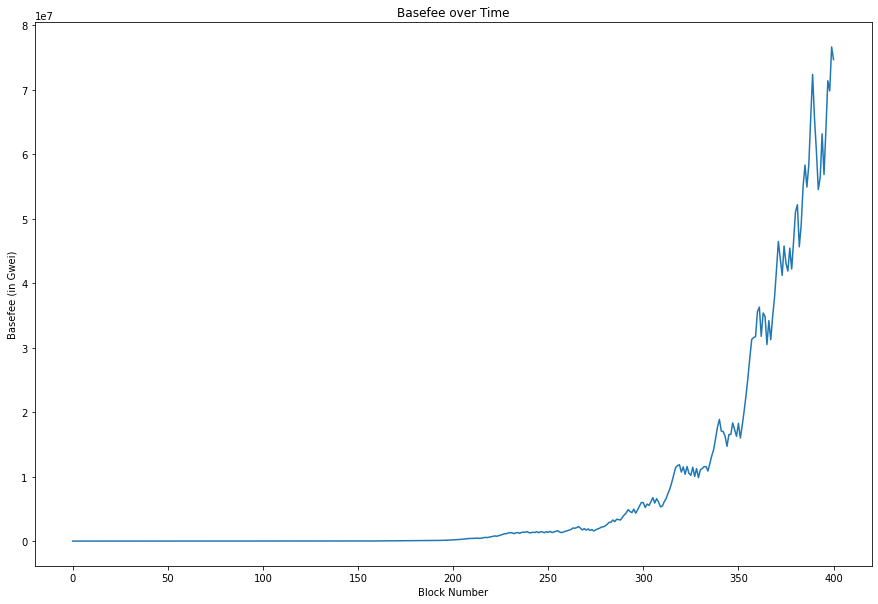

In [48]:
bf_standard = simulator.Basefee(1.0/8, 1500000, 3000000, 38.100002694) # d, target gas, max gas
# note our numbers are about 10x smaller, for sake of simplicity

bf_sim = simulator.Simulator(bf_standard, ("gas",), (1.0,))
s = bf_sim.simulate(400) # number of steps, and then initial basefee
basefees_data, blocks_data, new_txns, used_txns = s

plt.rcParams["figure.figsize"] = (15,10)
plt.title("Basefee over Time")
plt.xlabel("Block Number")
plt.ylabel("Basefee (in Gwei)")
plt.plot(basefees_data["gas"])

In [49]:
new_txns[40:70]

[276,
 248,
 304,
 123,
 252,
 289,
 92,
 59,
 65,
 106,
 147,
 61,
 337,
 348,
 61,
 293,
 374,
 154,
 154,
 345,
 51,
 17,
 177,
 254,
 121,
 59,
 389,
 184,
 40,
 172]

In [50]:
used_txns[40:70]

[6,
 2,
 3,
 5,
 4,
 5,
 4,
 2,
 1,
 7,
 1,
 4,
 1,
 5,
 4,
 2,
 4,
 6,
 5,
 5,
 4,
 2,
 0,
 6,
 5,
 4,
 1,
 5,
 4,
 1]

In [45]:
basefees_data["gas"][0:30]

[38.100002694,
 42.78224383524287,
 41.02343705148734,
 41.73407447448261,
 39.447380094051034,
 44.00948088543915,
 48.79294426765326,
 54.817204607637926,
 61.65356888765807,
 68.13146671463133,
 61.331477543411495,
 67.94580781691208,
 70.39090124142358,
 63.49444593596188,
 65.01284158200454,
 71.87417934183587,
 62.889906924106384,
 69.71771422609153,
 67.18106021247257,
 75.50364950679548,
 83.53442741860894,
 93.5414779408486,
 104.83330197121802,
 99.5591509871973,
 90.60909518657226,
 101.90358824767786,
 108.42699677593342,
 116.4380689522692,
 101.88331033323556,
 109.79991407308775]

# Two completely Correlated Resources

We now start with our first mental experiment with Multidimensional EIP-1559. Now every transaction uses 2 resources; e.g. the first being our old gas limit for EVM computation and second being EVM storage. Each of these should have their own basefees. Also suppose on average that we want to price them at a ratio such as 3:1 (so 1/4 of the money on average is spent on storage, from a user perspective).

We should scale the price of these resources because in reality, supply and demand should balance (else we aren't really comparing apples to apples). So we should scale so the first (computational) basefee is "worth" 3/4 as much as it used to, and the second (storage) basefee is "worth" 1/4 as the old one; (everything on average).

Now, we want to simulate the first example where the two resources are completely correlated. It should be intuitive that this means

- the basefees rise and drop at the same time
- the resulting (added) basefees should have identical behavior as the old basefee.

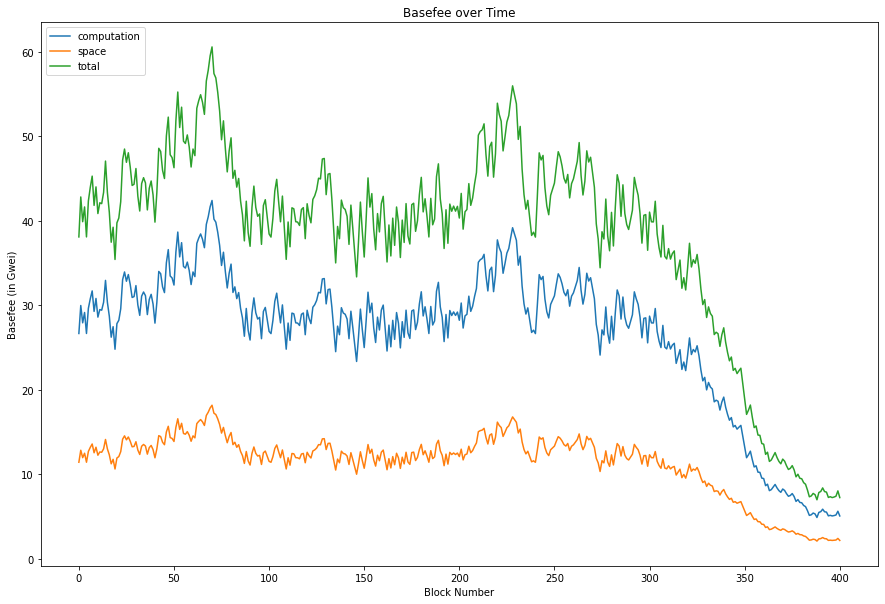

In [15]:
bf_standard = simulator.Basefee(1.0/8, 15000000, 30000000) # d, target gas, max gas
mbf_sim = simulator.MultiSimulator(bf_standard, ratio = [0.7, 0.3], basefee_behavior="CORRELATED")
ms = mbf_sim.simulate(400, 38.100002694) # number of steps, and then initial basefee
basefees_1_data, basefees_2_data, basefees_tot_data, blocks_data, mempools_data, mempools_bf_data, txn_counts_data, wait_times_data = ms

plt.rcParams["figure.figsize"] = (15,10)
plt.title("Basefee over Time")
plt.xlabel("Block Number")
plt.ylabel("Basefee (in Gwei)")
plt.plot(basefees_1_data, label="computation")
plt.plot(basefees_2_data, label="space")
plt.plot(basefees_tot_data, label="total")
plt.legend(loc="upper left")

# Two Independent Resources

Here we do something different; we have the randomly generated usage (over transactions) of the two resources be completely independent. Specifically, previously the generative model of completely correlated gas limits (knowing that the total gas limit in a transaction follows some distribution S) was:

1. sample X from S;
2. let the computation limit be 0.7X
3. let the space limit be 0.3X

Now what we do is
1. sample X, Y from S;
2. let computation limit be 0.7X
3. let space limit be 0.3Y

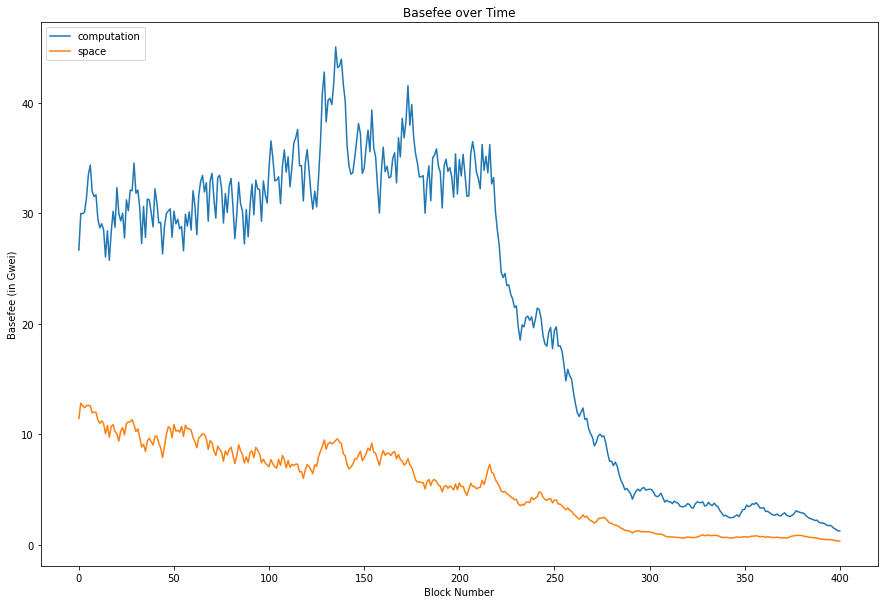

In [18]:
bf_standard = simulator.Basefee(1.0/8, 15000000, 30000000) # d, target gas, max gas
mbf_sim = simulator.MultiSimulator(bf_standard, ratio = [0.7, 0.3], basefee_behavior="INDEPENDENT")
ms = mbf_sim.simulate(400, 38.100002694) # number of steps, and then initial basefee
basefees_1_data, basefees_2_data, basefees_tot_data, blocks_data, mempools_data, mempools_bf_data, txn_counts_data, wait_times_data = ms

plt.rcParams["figure.figsize"] = (15,10)
plt.title("Basefee over Time")
plt.xlabel("Block Number")
plt.ylabel("Basefee (in Gwei)")
plt.plot(basefees_1_data, label="computation")
plt.plot(basefees_2_data, label="space")
plt.legend(loc="upper left")